# Sample Data Ingest

In [4]:
prototyping_datafolder=r"C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV"

In [5]:
from os import listdir,path
import pandas as pd

In [6]:
data_set=dict()
for datafolder in listdir(prototyping_datafolder):
    for sample in listdir(path.join(prototyping_datafolder,datafolder)):
        entry=dict()
        entry["dataset"]=datafolder
        entry["path"]=path.join(prototyping_datafolder,datafolder,sample)
        data_set[sample]=entry
df=pd.DataFrame(data_set).T
df

,dataset,path
sample_hdf0.tif,data_hdf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hdf1.tif,data_hdf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hdf2.tif,data_hdf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hdf3.tif,data_hdf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hov0.tif,data_hov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hov1.tif,data_hov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hov2.tif,data_hov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hov3.tif,data_hov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_ldf0.tif,data_ldf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_ldf1.tif,data_ldf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...


In [4]:
print(df.iloc[0].path)
display(df[df.dataset=="data_nov"])

C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV\data_hdf\sample_hdf0.tif


,dataset,path
sample_nov0.tif,data_nov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_nov1.tif,data_nov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_nov2.tif,data_nov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_nov3.tif,data_nov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...


# Image opening

In [5]:
from PIL import Image as PILImage

In [6]:
PILImage.open(df.iloc[0].path).show()

# Package Setups

## OpenCV

In [7]:
# https://docs.opencv.org/4.x/d5/de5/tutorial_py_setup_in_windows.html
# https://pypi.org/project/opencv-python/#manual-builds
# %pip install opencv-python
import cv2 as cv

In [ ]:
# https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html
# https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html

### SIFT

In [12]:
# SIFT https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
import numpy as np
import cv2 as cv
 
img = cv.imread(df.iloc[0].path)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
 
# img=cv.drawKeypoints(gray,kp,img)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# cv.imshow('sift_keypoints',img)
PILImage.fromarray(img).show()
# display(PILImage.fromarray(img))

In [14]:
kp,des = sift.compute(gray,kp)
display(des.shape)

(3045, 128)

### ORB

In [25]:
# https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html
img = cv.imread(df.iloc[0].path)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Initiate ORB detector
orb = cv.ORB_create()
 
# find the keypoints with ORB
kp = orb.detect(gray,None)
 
# compute the descriptors with ORB
kp, des = orb.compute(gray, kp)
 
# draw only keypoints location,not size and orientation
# img2 = cv.drawKeypoints(gray, kp, None, color=(0,255,0), flags=0)
img2=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
PILImage.fromarray(img2).show()

In [26]:
display(des.shape)

(500, 32)

### Matcher

In [ ]:
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

#### Brute-Force Matching w/ ORB

In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
 
img1 = cv.imread(df.iloc[0].path,cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread(df.iloc[1].path,cv.IMREAD_GRAYSCALE) # trainImage
 
# Initiate ORB detector
orb = cv.ORB_create()
 
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

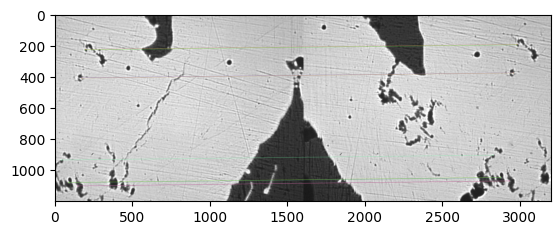

In [52]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
 
# Match descriptors.
matches = bf.match(des1,des2)
 
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
 
plt.imshow(img3)
plt.show()

In [38]:
kp2[matches[0].trainIdx].pt
kp1[matches[0].queryIdx].pt

(144.32260131835938, 1102.3260498046875)

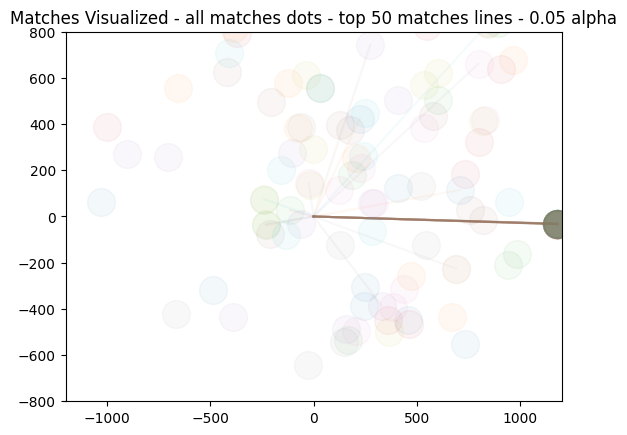

In [94]:
for i,match in enumerate(matches[:]):
    train_pt=kp2[match.trainIdx].pt
    query_pt=kp1[match.queryIdx].pt
    x_offset=train_pt[0]-query_pt[0]
    y_offset=train_pt[1]-query_pt[1]
    # print([x_offset],[y_offset])
    # plt.plot([0,x_offset],[0,y_offset],alpha=0.1)
    plt.plot([x_offset],[y_offset],"o",alpha=0.05,markersize=20)
    if i<50:
        plt.plot([0,x_offset],[0,y_offset],alpha=0.05)
plt.xlim([-1200,1200])
plt.ylim([-800,800])
plt.title("Matches Visualized - all matches dots - top 50 matches lines - 0.05 alpha")
plt.show()

## SimpleCV

In [ ]:
# Paused to focus on moving forward with OpenCV

## Scikit-Image

In [ ]:
# Paused to focus on moving forward with OpenCV

# Set Processing

In [159]:
# set_df=df[df.dataset=="data_hdf"].copy() # 2x2 high distinct feature set
set_df=df[df.dataset=="data_nov"].copy() # 4x1 low overlap set
set_df

,dataset,path
sample_nov0.tif,data_nov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_nov1.tif,data_nov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_nov2.tif,data_nov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_nov3.tif,data_nov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...


In [160]:
orb_data=dict()
for name,sample in set_df.iterrows():
    # print(sample)
    img = cv.imread(sample.path, cv.IMREAD_GRAYSCALE)
    orb = cv.ORB_create()
    kp, des = orb.detectAndCompute(img,None)
    orb_data[name]={"img":img,"kp":kp,"des":des}
orb_df=pd.DataFrame(orb_data).T
orb_df

,img,kp,des
sample_nov0.tif,"[[148, 147, 145, 145, 149, 152, 151, 151, 152,...","(< cv2.KeyPoint 00000147C72FA1F0>, < cv2.KeyPo...","[[175, 183, 245, 87, 191, 127, 183, 253, 127, ..."
sample_nov1.tif,"[[134, 134, 138, 141, 143, 143, 142, 141, 140,...","(< cv2.KeyPoint 00000147CA1AB8A0>, < cv2.KeyPo...","[[231, 173, 104, 86, 236, 73, 255, 235, 251, 2..."
sample_nov2.tif,"[[28, 30, 33, 37, 37, 36, 36, 36, 34, 31, 33, ...","(< cv2.KeyPoint 00000147C25C66D0>, < cv2.KeyPo...","[[69, 4, 235, 206, 180, 114, 111, 154, 81, 207..."
sample_nov3.tif,"[[41, 43, 42, 42, 41, 40, 42, 42, 40, 39, 37, ...","(< cv2.KeyPoint 00000147C2DE96B0>, < cv2.KeyPo...","[[125, 121, 231, 69, 129, 90, 110, 52, 97, 226..."


In [9]:
from itertools import combinations

In [ ]:
match_combs=combinations(set_df.index.to_list(),2)
# print(list(match_combs))
match_data=dict()
for m1,m2 in match_combs:
    print(m1,m2)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(orb_df["des"][m1],orb_df["des"][m2])
    matches = sorted(matches, key = lambda x:x.distance)
    img3 = cv.drawMatches(orb_df["img"][m1],orb_df["kp"][m1],orb_df["img"][m2],orb_df["kp"][m2],matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)
    plt.savefig(f"240815_OCV_MOSet_{m1[7:11]}-{m2[10:11]}-matches.png",bbox_inches="tight",dpi=300)
    plt.show()
    for i,match in enumerate(matches[:]):
        train_pt=orb_df["kp"][m2][match.trainIdx].pt
        query_pt=orb_df["kp"][m1][match.queryIdx].pt
        x_offset=train_pt[0]-query_pt[0]
        y_offset=train_pt[1]-query_pt[1]
        plt.plot([x_offset],[y_offset],"o",alpha=0.05,markersize=20)
        if i<50:
            plt.plot([0,x_offset],[0,y_offset],alpha=0.05)
    plt.xlim([-1600,1600])
    plt.ylim([-1200,1200])
    plt.savefig(f"240815_OCV_MOSet_{m1[7:11]}-{m2[10:11]}-offsets.png",bbox_inches="tight")
    plt.show()

# Offset Determination

## Prototyping
- lro2-3 for clean-defined
- lro0-2 for fuzzy rotated
- lro1-2 for similar feature but no match
- hdf0-2 for corner barely match
- hdf0-1 for clean-defined
- hdf1-3 for clean-defined
- lov2-3 for fuzzy match
- lov1-2 for fuzzy match
- ldf0-3 for clean match w/ noise
- ldf2-3 for clean match w/ noise


In [44]:
samples_short=["lro0","lro1","lro2","lro3","hdf0","hdf1","hdf2","hdf3","lov1","lov2","lov3","ldf0","ldf2","ldf3"]
samples=pd.DataFrame([df[df.index.str.contains(x)].iloc[0] for x in samples_short])
samples

,dataset,path
sample_lro0.jpg,data_lro,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_lro1.jpg,data_lro,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_lro2.jpg,data_lro,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_lro3.jpg,data_lro,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hdf0.tif,data_hdf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hdf1.tif,data_hdf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hdf2.tif,data_hdf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_hdf3.tif,data_hdf,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_lov1.tif,data_lov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...
sample_lov2.tif,data_lov,C:\Users\drago\Box\p_MIS-MISalign\data_AlignCV...


In [45]:
orb_data=dict()
for name,sample in samples.iterrows():
    # print(sample)
    img = cv.imread(sample.path, cv.IMREAD_GRAYSCALE)
    orb = cv.ORB_create()
    kp, des = orb.detectAndCompute(img,None)
    orb_data[name]={"img":img,"kp":kp,"des":des}
orb_df=pd.DataFrame(orb_data).T
orb_df

,img,kp,des
sample_lro0.jpg,"[[37, 36, 34, 33, 32, 31, 31, 31, 36, 36, 37, ...","(< cv2.KeyPoint 000001FC75F99830>, < cv2.KeyPo...","[[255, 102, 226, 52, 235, 56, 220, 200, 251, 1..."
sample_lro1.jpg,"[[114, 113, 112, 111, 111, 112, 114, 115, 113,...","(< cv2.KeyPoint 000001FC76037000>, < cv2.KeyPo...","[[248, 91, 114, 236, 54, 147, 91, 80, 5, 36, 2..."
sample_lro2.jpg,"[[113, 113, 113, 112, 112, 111, 111, 111, 114,...","(< cv2.KeyPoint 000001FC7140B0C0>, < cv2.KeyPo...","[[131, 139, 26, 218, 125, 157, 234, 230, 159, ..."
sample_lro3.jpg,"[[115, 114, 113, 112, 112, 112, 113, 113, 113,...","(< cv2.KeyPoint 000001FC71430F00>, < cv2.KeyPo...","[[66, 151, 47, 137, 146, 167, 184, 51, 172, 1,..."
sample_hdf0.tif,"[[196, 191, 188, 185, 182, 179, 180, 180, 176,...","(< cv2.KeyPoint 000001FC71436D00>, < cv2.KeyPo...","[[56, 201, 8, 170, 28, 197, 75, 236, 22, 4, 20..."
sample_hdf1.tif,"[[205, 208, 208, 207, 205, 206, 204, 202, 199,...","(< cv2.KeyPoint 000001FC7143CB40>, < cv2.KeyPo...","[[72, 56, 149, 112, 169, 108, 81, 3, 171, 191,..."
sample_hdf2.tif,"[[43, 48, 53, 57, 56, 56, 57, 58, 53, 49, 50, ...","(< cv2.KeyPoint 000001FC71442940>, < cv2.KeyPo...","[[109, 241, 184, 98, 253, 93, 86, 220, 235, 25..."
sample_hdf3.tif,"[[198, 196, 196, 198, 198, 198, 199, 200, 196,...","(< cv2.KeyPoint 000001FC71448780>, < cv2.KeyPo...","[[3, 141, 2, 159, 221, 135, 174, 231, 158, 73,..."
sample_lov1.tif,"[[198, 201, 196, 191, 187, 183, 172, 162, 166,...","(< cv2.KeyPoint 000001FC7144E580>, < cv2.KeyPo...","[[7, 120, 174, 67, 34, 39, 187, 208, 38, 123, ..."
sample_lov2.tif,"[[187, 176, 171, 167, 173, 180, 207, 236, 221,...","(< cv2.KeyPoint 000001FC714543C0>, < cv2.KeyPo...","[[64, 206, 158, 190, 120, 132, 62, 182, 168, 6..."


In [46]:
from scipy import ndimage

In [47]:
# match_combs=combinations(orb_df.index.to_list(),2)
match_combs=(("lro2","lro3"),("lro0","lro2"),("lro1","lro2"),("hdf0","hdf2"),("hdf0","hdf1"),("hdf1","hdf3"),("lov2","lov3"),("lov1","lov2"),("ldf0","ldf3"),("ldf2","ldf3"))
match_combs=[(df.index[df.index.str.contains(x[0])][0],df.index[df.index.str.contains(x[1])][0]) for x in match_combs]

match_combs

[('sample_lro2.jpg', 'sample_lro3.jpg'),
 ('sample_lro0.jpg', 'sample_lro2.jpg'),
 ('sample_lro1.jpg', 'sample_lro2.jpg'),
 ('sample_hdf0.tif', 'sample_hdf2.tif'),
 ('sample_hdf0.tif', 'sample_hdf1.tif'),
 ('sample_hdf1.tif', 'sample_hdf3.tif'),
 ('sample_lov2.tif', 'sample_lov3.tif'),
 ('sample_lov1.tif', 'sample_lov2.tif'),
 ('sample_ldf0.tif', 'sample_ldf3.tif'),
 ('sample_ldf2.tif', 'sample_ldf3.tif')]

sample_lro2.jpg sample_lro3.jpg Offset: [-742  -22]


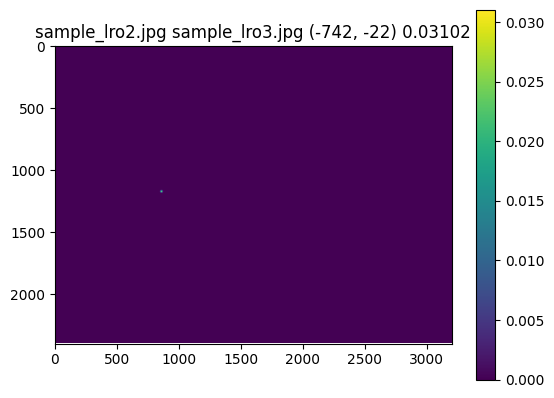

sample_lro0.jpg sample_lro2.jpg Offset: [  58 -849]


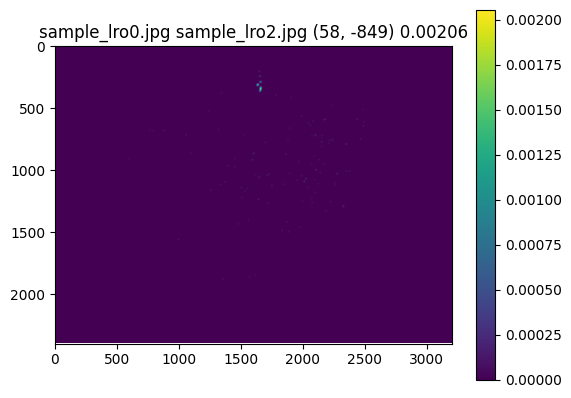

sample_lro1.jpg sample_lro2.jpg Offset: [ 519 -584]


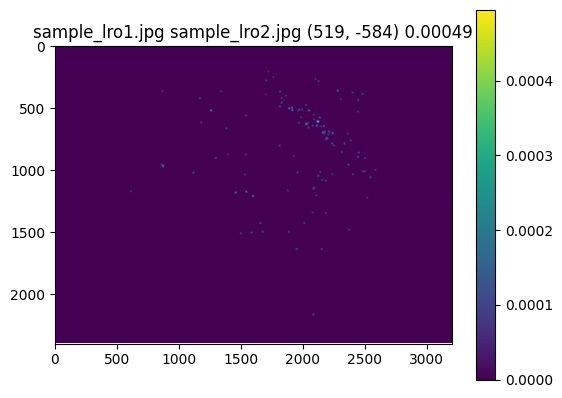

sample_hdf0.tif sample_hdf2.tif Offset: [1169 -866]


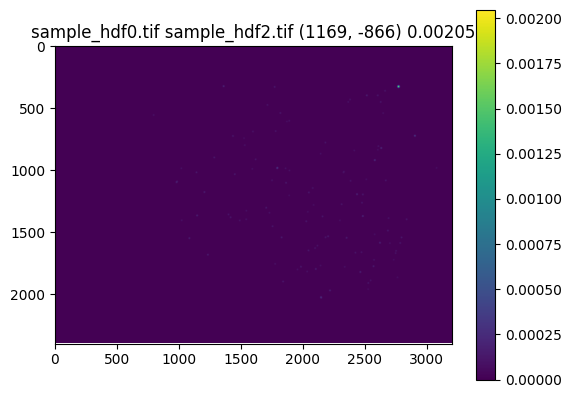

sample_hdf0.tif sample_hdf1.tif Offset: [1179  -33]


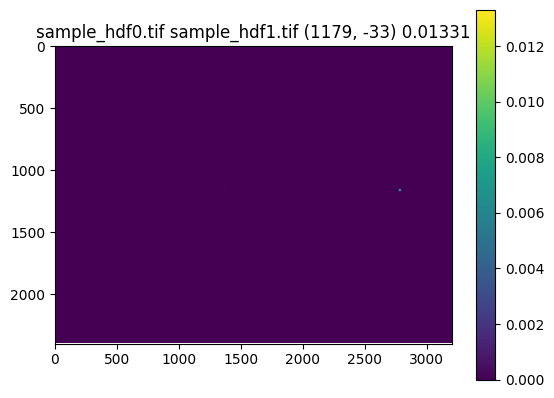

sample_hdf1.tif sample_hdf3.tif Offset: [-1058  -830]


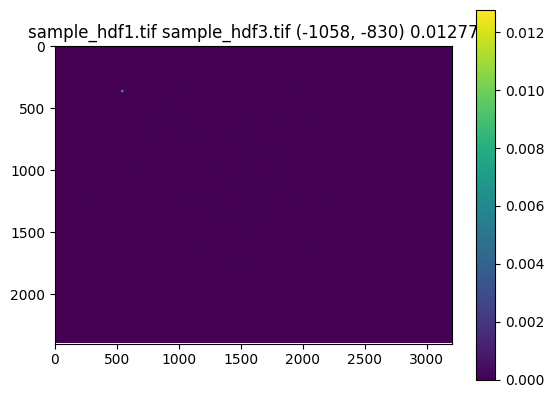

sample_lov2.tif sample_lov3.tif Offset: [-1348   -10]


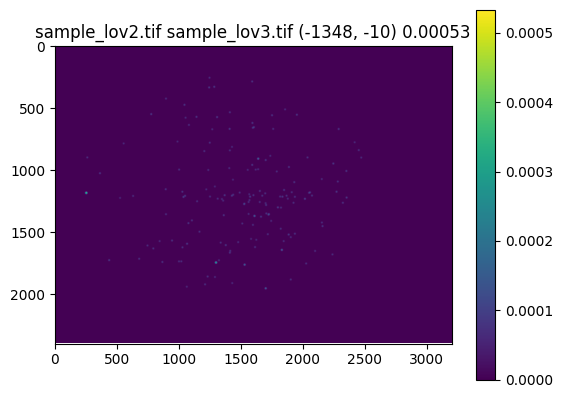

sample_lov1.tif sample_lov2.tif Offset: [-410 -482]


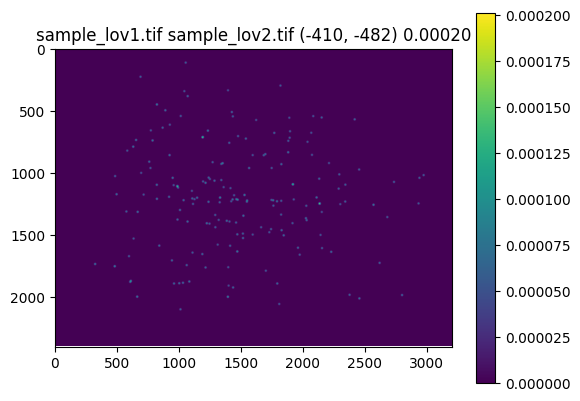

sample_ldf0.tif sample_ldf3.tif Offset: [-1  1]


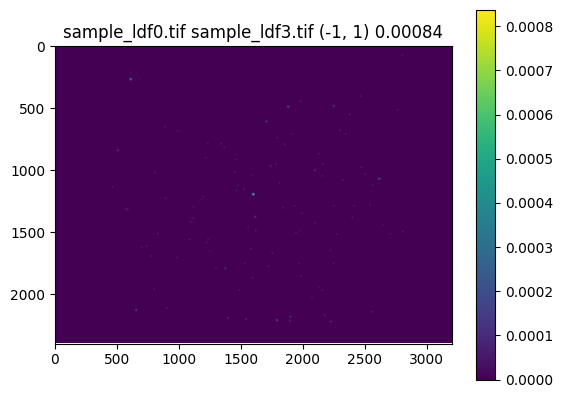

sample_ldf2.tif sample_ldf3.tif Offset: [-1177   -43]


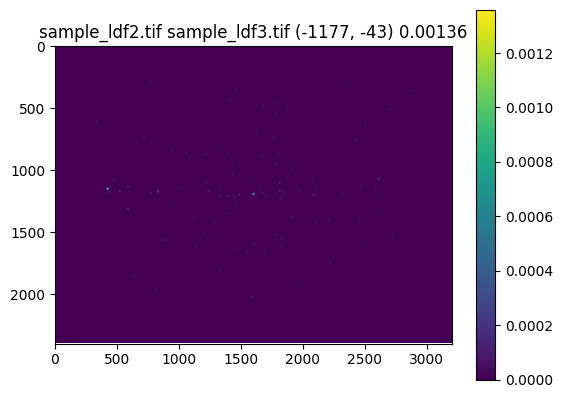

In [54]:
for m1,m2 in match_combs:
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(orb_df["des"][m1],orb_df["des"][m2])
    matches = sorted(matches, key = lambda x:x.distance)
    offset_grid=np.zeros((3200,2400),dtype=float)
    for i,match in enumerate(matches[:]):
        train_pt=orb_df["kp"][m2][match.trainIdx].pt
        query_pt=orb_df["kp"][m1][match.queryIdx].pt
        x_offset_adj=int(train_pt[0]-query_pt[0]+1600) #1600/1200 centers in numpy array/image.
        y_offset_adj=int(train_pt[1]-query_pt[1]+1200)
        offset_grid[x_offset_adj,y_offset_adj]+=1/match.distance
    offset_grid=ndimage.gaussian_filter(offset_grid,5)
    print(m1,m2,"Offset:",np.array(np.unravel_index(np.argmax(offset_grid),offset_grid.shape))-np.array([1600,1200]))
    plt.title(" ".join([m1,m2,str(tuple(np.array(np.unravel_index(np.argmax(offset_grid),offset_grid.shape))-np.array([1600,1200]))),f"{offset_grid.max():.5f}"]))
    plt.imshow(offset_grid.T)
    plt.colorbar()
    plt.savefig(f"240815_OffsetMap_{m1[7:11]}-{m2[10:11]}-offmap-g5.png",bbox_inches="tight",dpi=300)
    plt.show()
    # img3 = cv.drawMatches(orb_df["img"][m1],orb_df["kp"][m1],orb_df["img"][m2],orb_df["kp"][m2],matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # plt.imshow(img3)
    # plt.savefig(f"240815_OCV_MOSet_{m1[7:11]}-{m2[10:11]}-matches.png",bbox_inches="tight",dpi=300)
    # plt.show()
    # for i,match in enumerate(matches[:]):
    #     train_pt=orb_df["kp"][m2][match.trainIdx].pt
    #     query_pt=orb_df["kp"][m1][match.queryIdx].pt
    #     x_offset=train_pt[0]-query_pt[0]
    #     y_offset=train_pt[1]-query_pt[1]
    #     plt.plot([x_offset],[y_offset],"o",alpha=0.05,markersize=20)
    #     if i<50:
    #         plt.plot([0,x_offset],[0,y_offset],alpha=0.05)
    # plt.xlim([-1600,1600])
    # plt.ylim([-1200,1200])
    # plt.savefig(f"240815_OCV_MOSet_{m1[7:11]}-{m2[10:11]}-offsets.png",bbox_inches="tight")
    # plt.show()